# data load

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.set_option('display.max_columns', 35)  ## 생략 없이 한 번에 띄울 피쳐수 = 35
df0 = pd.read_parquet( "../data/df0.parquet" )
df1 = pd.read_parquet( "../data/df1.parquet" )  ### 추가 피쳐: 페이백율, 할인률, 종합혜택률, 구매시각추출, 구매건카운트
df2 = pd.read_parquet( "../data/df2.parquet" )
df3 = pd.read_parquet( "../data/df3.parquet" )  ### 추가 피쳐: 가입시각추출, 상업코드

print(df0.shape, df1.shape, df2.shape, df3.shape, sep=" "*5)
# display(df0.head(2))
# display(df1.head(2))
# display(df2.head(2))
# display(df3.head(2))

(5623810, 14)     (5623810, 23)     (544921, 17)     (544921, 31)


In [132]:
## 지수 표기법 변경
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

# Segmentation을 위한 feature 생성

## 날짜 활용
- 월별 구매 횟수 구하기
- 구매 시기에 따라 차등을 두어 점수 계산 (3월->4점, 9월->1점 등)

In [133]:
# 월별 가중치
def month_weight(x):
    if x == 8:
        return 0.3
    elif x == 9:
        return 0.6
    elif x == 10:
        return 0.9
    elif x == 11:
        return 1.2
    elif x == 12:
        return 1.5
    elif x == 1:
        return 1.8
    elif x == 2:
        return 2.1
    else:
        return 2.4

In [134]:
# 인당 월별 구매 횟수
a = df1.groupby(['id','buy_m']).count().reset_index()[['id','buy_m','cnt_b']]
b = df1.groupby(['buy_m']).count().reset_index()[['buy_m','push']]
aa = a.groupby('buy_m').count().reset_index()
aa = aa.merge(b,on='buy_m')
aa = aa.rename(columns={'push':'cnt'})

# 월 평균 구매 횟수
aa['avg_cnt'] = aa['cnt']/aa['id']
a = a.merge(aa[['buy_m','avg_cnt']],on='buy_m')
a['m_point'] = a['buy_m'].apply(month_weight)

# 평균 구매 횟수를 넘겼으면 가중치 부여
a['avg_result'] = 0
a.loc[a['cnt_b']>a['avg_cnt'],'avg_result'] = 1
a['score'] = a['m_point']*a['avg_result']
aaa = a.groupby('id').sum().reset_index()

# score로 합계
df2 = df2.merge(aaa[['id','score']],on='id')

## 기존 feature 중 그대로 사용할 feature
- man
- push
- frgn

## 성별

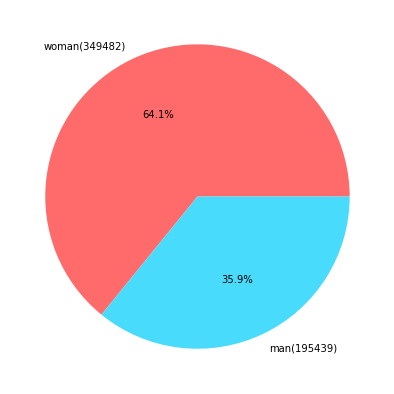

In [135]:
plt.figure(figsize=(7,7),facecolor="white")
man = df2[df2['man'].values==1]['man'].count()
woman = df2[df2['man'].values!=1]['man'].count()
labels = ['woman'+'('+str(woman)+')','man'+'('+str(man)+')']
plt.pie(df2['man'].value_counts(),labels=labels,autopct='%.1f%%',colors=['#ff6b6b','#48dbfb'])
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/2230119164.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/2230119164.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


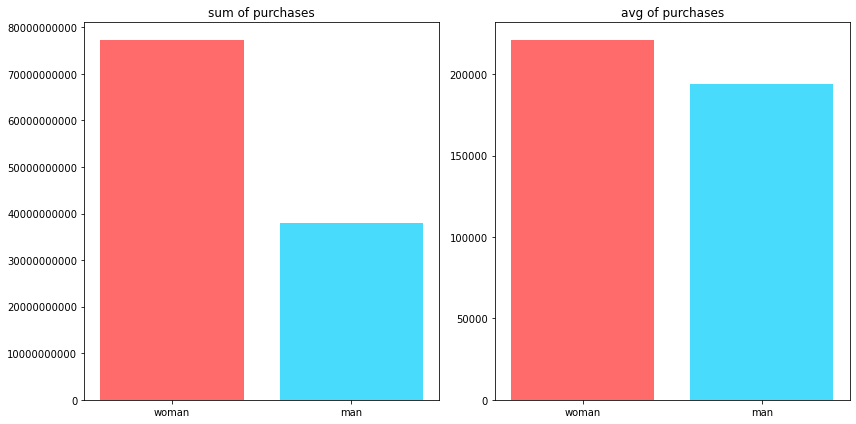

In [136]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
a = df2.groupby('man').sum()['pre'].reset_index()
a.iloc[0,0] = 'woman'
a.iloc[1,0] = 'man'
plt.title('sum of purchases')
plt.bar(a['man'],a['pre'],color=['#ff6b6b','#48dbfb'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
b = df2.groupby('man').mean()['pre'].reset_index()
b.iloc[0,0] = 'woman'
b.iloc[1,0] = 'man'
plt.title('avg of purchases')
plt.bar(b['man'],b['pre'],color=['#ff6b6b','#48dbfb'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [137]:
# 점수 생성
def s_gender(man):
    if man == 1:
        return 2.5
    else:
        return 7.5

## push 알림 설정 여부

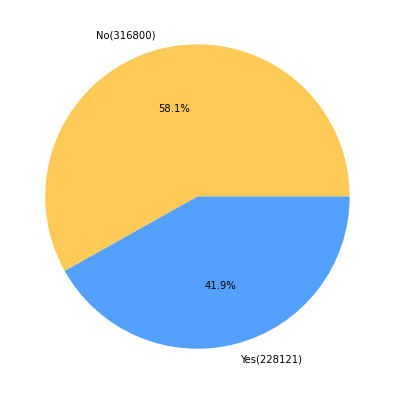

In [138]:
plt.figure(figsize=(7,7),facecolor="white")
yes = df2[df2['push'].values==1]['push'].count()
no = df2[df2['push'].values!=1]['push'].count()
labels = ['No'+'('+str(no)+')','Yes'+'('+str(yes)+')']
plt.pie(df2['push'].value_counts(),labels=labels,autopct='%.1f%%',colors=['#feca57','#54a0ff'])
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/2882050237.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/2882050237.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


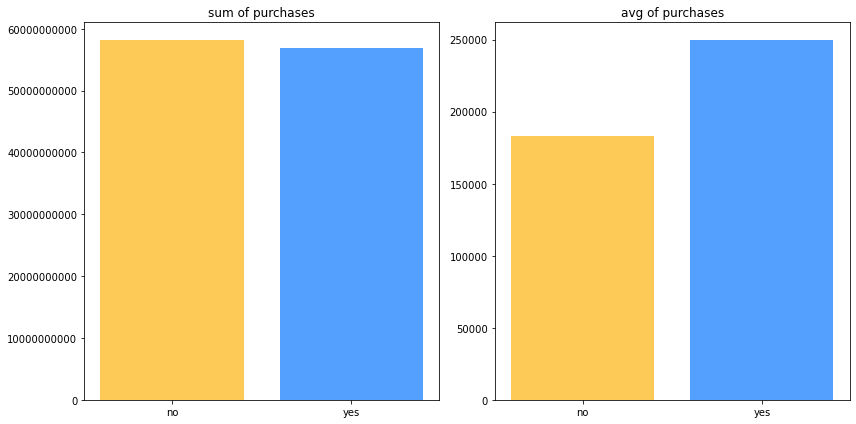

In [139]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
a = df2.groupby('push').sum()['pre'].reset_index()
a.iloc[0,0] = 'no'
a.iloc[1,0] = 'yes'
plt.title('sum of purchases')
plt.bar(a['push'],a['pre'],color=['#feca57','#54a0ff'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
b = df2.groupby('push').mean()['pre'].reset_index()
b.iloc[0,0] = 'no'
b.iloc[1,0] = 'yes'
plt.title('avg of purchases')
plt.bar(b['push'],b['pre'],color=['#feca57','#54a0ff'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [140]:
# 점수 생성
def s_push(push):
    if push == 0:
        return 2.5
    else:
        return 7.5

## 연령대별

/Users/luci031/opt/anaconda3/envs/spark/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

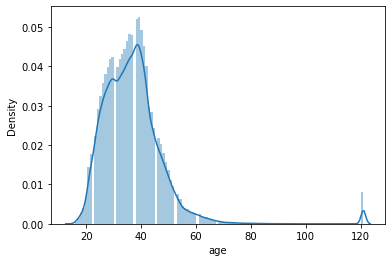

In [141]:
sns.distplot(df2['age'],bins=120)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/1866640328.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/1866640328.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


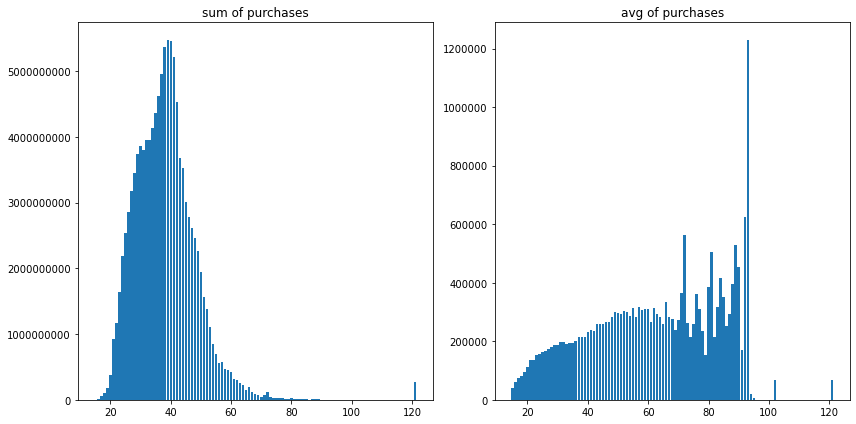

In [142]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df2.groupby('age').sum()['pre'].index,df2.groupby('age').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df2.groupby('age').mean()['pre'].index,df2.groupby('age').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [143]:
#눈에 띄는 지점 기준으로 나누기
print('~29세')
display(df2[df2['age']<30].describe())
print('30~39세')
display(df2[(df2['age']>=30) & (df2['age']<40)].describe())
print('40~59세')
display(df2[(df2['age']>=40) & (df2['age']<60)].describe())
print('60세~')
display(df2[df2['age']>=60].describe())

~29세


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000,138105.000
mean,271724.482,25.419,0.303,0.366,0.007,162478.904,151771.187,1050.427,10707.716,11758.143,0.514,11.468,11.982,1.000,7.867,0.897
std,157150.056,2.806,0.460,0.482,0.080,339014.587,324765.201,4164.776,17261.274,19100.424,0.959,12.288,12.041,0.000,15.214,1.994
min,2.000,15.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,135784.000,24.000,0.000,0.000,0.000,22430.000,19000.000,0.000,2000.000,2300.000,0.000,4.600,5.400,1.000,1.000,0.000
50%,271322.000,26.000,0.000,0.000,0.000,60700.000,55200.000,0.000,5000.000,5501.000,0.000,8.300,8.600,1.000,3.000,0.000
75%,407641.000,28.000,1.000,1.000,0.000,175550.000,163800.000,714.000,11700.000,12818.000,0.600,13.400,13.700,1.000,8.000,0.600
max,544918.000,29.000,1.000,1.000,1.000,25362070.000,24594730.000,851803.000,767340.000,961803.000,5.000,100.000,100.000,1.000,1363.000,10.800


30~39세


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000,220886.000
mean,272950.319,34.745,0.349,0.336,0.007,201489.791,187248.285,1168.492,14241.506,15409.998,0.430,12.585,13.015,1.000,9.624,1.057
std,157369.431,2.882,0.477,0.472,0.085,545505.134,525025.446,4491.900,24924.355,27177.152,0.891,12.346,12.158,0.000,20.089,2.218
min,1.000,30.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136653.500,32.000,0.000,0.000,0.000,23850.000,20000.000,0.000,2419.250,3000.000,0.000,5.800,6.400,1.000,1.000,0.000
50%,273386.500,35.000,0.000,0.000,0.000,65600.000,58600.000,0.000,6185.000,6980.000,0.000,9.300,9.700,1.000,3.000,0.000
75%,409493.750,37.000,1.000,1.000,0.000,196030.000,180760.750,579.000,15175.750,16390.000,0.400,15.100,15.300,1.000,10.000,1.200
max,544921.000,39.000,1.000,1.000,1.000,110444100.000,108395600.000,248180.000,2048500.000,2198593.000,5.000,100.000,100.000,1.000,2705.000,10.800


40~59세


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000,173029.000
mean,272427.289,45.234,0.414,0.556,0.003,260984.740,242708.920,1571.317,18275.820,19847.137,0.424,12.032,12.456,1.000,13.121,1.437
std,157299.391,4.658,0.492,0.497,0.058,663671.747,635759.203,5484.286,32640.624,35473.958,0.861,11.531,11.348,0.000,24.578,2.638
min,3.000,40.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136131.000,41.000,0.000,0.000,0.000,26310.000,22499.000,0.000,3000.000,3501.000,0.000,5.800,6.500,1.000,1.000,0.000
50%,272296.000,44.000,0.000,1.000,0.000,78420.000,70640.000,0.000,7000.000,7915.000,0.000,9.200,9.500,1.000,4.000,0.000
75%,408463.000,48.000,1.000,1.000,0.000,260200.000,239761.000,792.000,19733.000,21132.000,0.500,14.200,14.400,1.000,13.000,1.800
max,544920.000,59.000,1.000,1.000,1.000,115005350.000,112273800.000,249438.000,2731550.000,2731550.000,5.000,100.000,100.000,1.000,464.000,10.800


60세~


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000,12901.000
mean,272419.610,82.180,0.385,0.559,0.004,227388.543,211360.053,1147.968,16028.490,17176.458,0.292,19.431,19.724,1.000,10.946,1.105
std,157932.362,25.989,0.487,0.497,0.062,695771.826,668423.049,5458.440,32317.717,34741.586,0.765,22.030,21.873,0.000,24.340,2.389
min,69.000,60.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,135890.000,62.000,0.000,0.000,0.000,14610.000,11040.000,0.000,3000.000,3000.000,0.000,6.600,7.100,1.000,1.000,0.000
50%,269704.000,67.000,0.000,1.000,0.000,40600.000,34800.000,0.000,5050.000,5775.000,0.000,11.100,11.100,1.000,2.000,0.000
75%,409408.000,121.000,1.000,1.000,0.000,165110.000,150035.000,0.000,14520.000,15537.000,0.000,22.900,23.000,1.000,9.000,0.900
max,544842.000,121.000,1.000,1.000,1.000,33798700.000,33027600.000,312593.000,807400.000,808678.000,5.000,100.000,100.000,1.000,385.000,10.800


In [144]:
# 점수 생성
def s_age(age):
    if age < 30:
        return 1
    elif 30 <= age < 40:
        return 2
    elif 40 <= age < 60:
        return 4
    else:
        return 3

## 구매 횟수별 (once and more)

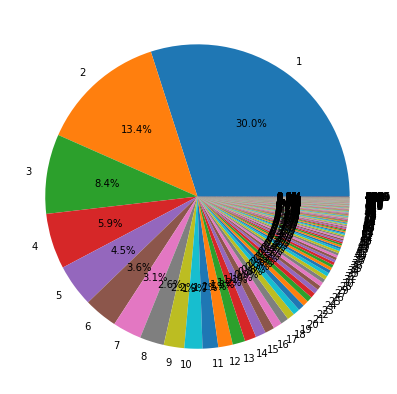

In [145]:
plt.figure(figsize=(7,7),facecolor="white")
labels = df2['cnt_b'].value_counts().index.to_list()
plt.pie(df2['cnt_b'].value_counts(),labels=labels,autopct='%.1f%%')
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/1445558188.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/1445558188.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


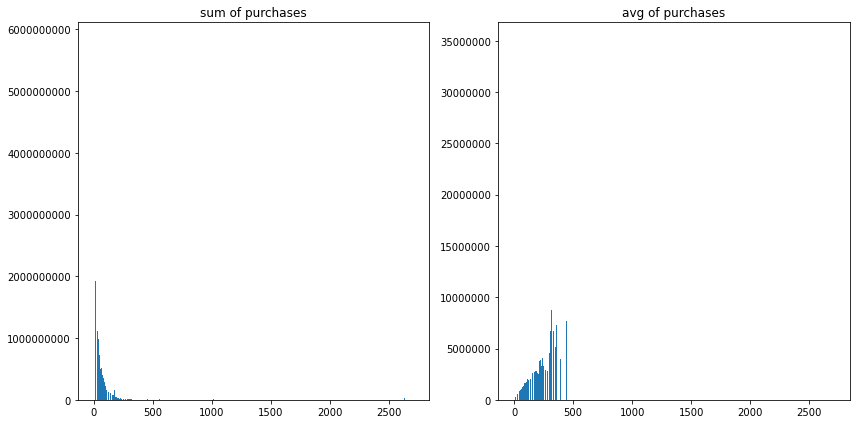

In [146]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df2.groupby('cnt_b').sum()['pre'].index,df2.groupby('cnt_b').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df2.groupby('cnt_b').mean()['pre'].index,df2.groupby('cnt_b').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [147]:
#눈에 띄는 지점 기준으로 나누기
print('1회')
display(df2[df2['cnt_b']<2].describe())
print('2~3회')
display(df2[(df2['cnt_b']>=2) & (df2['cnt_b']<4)].describe())
print('4~10회')
display(df2[(df2['cnt_b']>=4) & (df2['cnt_b']<11)].describe())
print('11회~')
display(df2[df2['cnt_b']>=11].describe())

1회


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000,163227.000
mean,272553.842,36.884,0.400,0.374,0.004,35677.349,32686.630,102.533,2990.719,3093.252,0.240,17.305,17.545,1.000,1.000,0.000
std,157021.312,14.544,0.490,0.484,0.064,82129.937,80606.849,1042.672,2952.574,3041.888,0.871,18.598,18.443,0.000,0.000,0.000
min,3.000,15.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136992.000,28.000,0.000,0.000,0.000,10560.000,7900.000,0.000,1501.000,1501.000,0.000,5.100,5.300,1.000,1.000,0.000
50%,272484.000,35.000,0.000,0.000,0.000,16500.000,13900.000,0.000,2000.000,2000.000,0.000,11.200,11.300,1.000,1.000,0.000
75%,408381.000,41.000,1.000,1.000,0.000,29800.000,27300.000,0.000,5000.000,5000.000,0.000,22.700,22.800,1.000,1.000,0.000
max,544913.000,121.000,1.000,1.000,1.000,1990950.000,1985950.000,94772.000,58000.000,94772.000,5.000,100.000,100.000,1.000,1.000,0.000


2~3회


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000,119180.000
mean,272735.881,36.328,0.392,0.393,0.005,70849.770,65590.136,258.768,5259.634,5518.401,0.402,12.497,12.899,1.000,2.386,0.000
std,157321.855,10.735,0.488,0.488,0.067,147277.241,143732.805,1296.826,5303.438,5342.903,0.921,10.218,10.014,0.000,0.487,0.000
min,1.000,15.000,0.000,0.000,0.000,1000.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,0.000
25%,136358.000,29.000,0.000,0.000,0.000,25470.000,21400.000,0.000,2491.000,3000.000,0.000,5.700,6.300,1.000,2.000,0.000
50%,272672.500,36.000,0.000,0.000,0.000,38750.000,34340.000,0.000,4000.000,4501.000,0.000,10.200,10.500,1.000,2.000,0.000
75%,408999.000,41.000,1.000,1.000,0.000,64920.000,59700.000,0.000,6800.000,7000.000,0.000,16.500,16.800,1.000,3.000,0.000
max,544917.000,121.000,1.000,1.000,1.000,2876400.000,2815200.000,92856.000,508000.000,508000.000,5.000,92.100,92.100,1.000,3.000,0.000


4~10회


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000,129180.000
mean,272613.534,36.395,0.360,0.416,0.005,149083.965,138359.556,703.493,10724.410,11427.903,0.530,10.111,10.641,1.000,6.257,0.506
std,157740.499,9.719,0.480,0.493,0.073,251964.142,245267.457,2037.848,8862.680,8847.334,0.915,6.967,6.728,0.000,1.950,0.846
min,4.000,15.000,0.000,0.000,0.000,4639.000,4235.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000,0.000
25%,135707.500,30.000,0.000,0.000,0.000,65512.250,57580.000,0.000,6000.000,6850.750,0.000,5.600,6.300,1.000,5.000,0.000
50%,272833.500,36.000,0.000,0.000,0.000,100080.000,90699.000,0.000,9190.000,9954.500,0.000,8.700,9.100,1.000,6.000,0.000
75%,409635.750,41.000,1.000,1.000,0.000,156542.500,145300.000,738.000,13180.250,13850.000,0.700,12.700,12.900,1.000,8.000,0.900
max,544921.000,121.000,1.000,1.000,1.000,9492800.000,9158600.000,99651.000,334200.000,335020.000,5.000,68.800,68.800,1.000,10.000,4.500


11회~


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000,133334.000
mean,271953.860,37.654,0.277,0.498,0.009,611328.260,570129.613,4135.574,41198.647,45334.222,0.656,8.071,8.727,1.000,32.759,4.162
std,157216.178,9.673,0.448,0.500,0.096,963320.182,928930.276,8690.822,42167.615,45763.250,0.833,4.154,3.934,0.000,32.875,3.012
min,23.000,16.000,0.000,0.000,0.000,19761.000,13922.000,0.000,0.000,746.000,0.000,0.000,0.400,1.000,11.000,0.000
25%,135671.750,31.000,0.000,0.000,0.000,239080.000,218289.250,117.000,18750.000,20771.000,0.000,5.500,6.400,1.000,15.000,1.800
50%,271832.000,37.000,0.000,0.000,0.000,397057.000,367579.500,1500.000,29506.500,32037.000,0.400,7.500,8.000,1.000,22.000,3.600
75%,407876.250,43.000,1.000,1.000,0.000,706145.500,657878.750,4554.000,49527.000,53869.750,0.900,9.700,10.100,1.000,38.000,6.300
max,544919.000,121.000,1.000,1.000,1.000,115005350.000,112273800.000,851803.000,2731550.000,2731550.000,5.000,52.600,52.600,1.000,2705.000,10.800


In [148]:
# 점수 생성
def s_cnt_b(cnt_b):
    if cnt_b < 2:
        return 1
    elif 2 <= cnt_b < 4:
        return 2
    elif 4 <= cnt_b < 11:
        return 3
    else:
        return 4

## 구매 금액별 (heavy and light)

In [149]:
df2['pre'].describe()

count      544921.000
mean       211107.465
std        550003.100
min           500.000
25%         23800.000
50%         67300.000
75%        206356.000
max     115005350.000
Name: pre, dtype: float64

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/2437683103.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values1])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/2437683103.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values2])


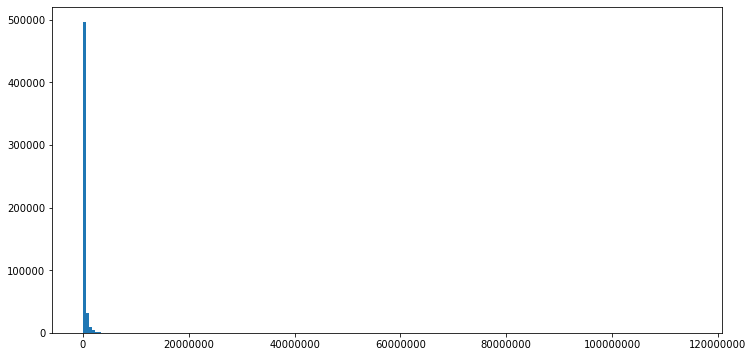

In [150]:
plt.figure(figsize=(12,6),facecolor="white")
plt.hist(df2['pre'],bins=200)
current_values1 = plt.gca().get_yticks()
current_values2 = plt.gca().get_xticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values1])
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values2])
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/3244094015.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values1])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/3244094015.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values2])


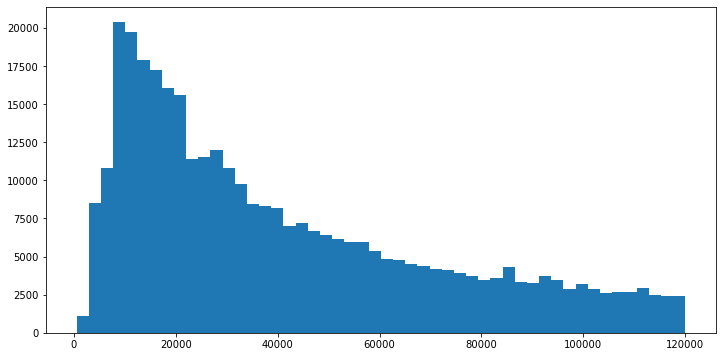

In [151]:
# 12만원 이하 금액들 분포 살피기
plt.figure(figsize=(12,6),facecolor="white")
plt.hist(df2[df2['pre']<=120000]['pre'],bins=50)
current_values1 = plt.gca().get_yticks()
current_values2 = plt.gca().get_xticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values1])
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values2])
plt.show()

In [152]:
#눈에 띄는 지점 기준으로 나누기
print('~2만원')
display(df2[df2['post']<20000].describe())
print('2~8만원')
display(df2[(df2['post']>=20000) & (df2['post']<80000)].describe())
print('8~20만원')
display(df2[(df2['post']>=80000) & (df2['post']<200000)].describe())
print('20만원~')
display(df2[df2['post']>=200000].describe())

~2만원


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000,135603.000
mean,272305.827,37.341,0.402,0.372,0.004,13731.900,10831.171,28.656,2900.729,2929.385,0.223,22.800,23.023,1.000,1.272,0.004
std,157302.277,14.552,0.490,0.483,0.062,5668.272,5152.521,108.777,2295.298,2279.868,0.800,19.489,19.342,0.000,0.611,0.085
min,1.000,15.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136338.000,29.000,0.000,0.000,0.000,9800.000,7120.000,0.000,1501.000,1501.000,0.000,11.100,11.100,1.000,1.000,0.000
50%,272101.000,36.000,0.000,0.000,0.000,13400.000,10500.000,0.000,2000.000,2000.000,0.000,18.300,18.300,1.000,1.000,0.000
75%,408686.500,41.000,1.000,1.000,0.000,17850.000,15120.000,0.000,4700.000,4726.500,0.000,31.200,31.200,1.000,1.000,0.000
max,544913.000,121.000,1.000,1.000,1.000,41900.000,19999.000,1710.000,23000.000,23000.000,5.000,100.000,100.000,1.000,11.000,4.500


2~8만원


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000,170496.000
mean,272650.086,36.422,0.358,0.402,0.005,48864.419,43462.300,204.459,5402.119,5606.579,0.418,11.049,11.467,1.000,3.090,0.132
std,157334.338,11.086,0.480,0.490,0.070,18614.878,16846.379,472.998,4087.575,4029.234,0.927,6.882,6.635,0.000,2.165,0.485
min,5.000,15.000,0.000,0.000,0.000,20000.000,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136542.750,29.000,0.000,0.000,0.000,32800.000,28500.000,0.000,2000.000,2780.000,0.000,6.400,6.800,1.000,1.000,0.000
50%,272429.000,36.000,0.000,0.000,0.000,45600.000,40400.000,0.000,5000.000,5000.000,0.000,10.200,10.500,1.000,3.000,0.000
75%,409056.250,41.000,1.000,1.000,0.000,62700.000,56220.000,72.000,7000.000,7134.000,0.100,15.000,15.200,1.000,4.000,0.000
max,544917.000,121.000,1.000,1.000,1.000,134310.000,79999.000,5378.000,55390.000,55390.000,5.000,52.600,52.600,1.000,34.000,6.300


8~20만원


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000,107510.000
mean,272590.018,36.007,0.357,0.422,0.005,140340.001,128995.828,749.838,11344.173,12094.012,0.544,7.969,8.512,1.000,7.668,0.799
std,157678.470,9.933,0.479,0.494,0.073,37065.506,34083.160,1330.465,7568.974,7376.270,0.945,4.538,4.302,0.000,5.151,1.222
min,8.000,15.000,0.000,0.000,0.000,80000.000,80000.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,135456.250,29.000,0.000,0.000,0.000,108530.000,98979.250,0.000,6000.000,7000.000,0.000,4.800,5.600,1.000,4.000,0.000
50%,273207.500,35.000,0.000,0.000,0.000,135990.000,124468.500,0.000,10000.000,10839.000,0.000,7.600,8.100,1.000,7.000,0.000
75%,409261.500,41.000,1.000,1.000,0.000,169180.000,155700.000,1003.000,15000.000,15450.750,0.700,10.400,10.700,1.000,10.000,1.500
max,544911.000,121.000,1.000,1.000,1.000,397100.000,199999.000,12453.000,305000.000,305000.000,5.000,76.800,76.800,1.000,68.000,9.300


20만원~


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000,131312.000
mean,272270.102,37.524,0.315,0.485,0.009,683529.782,641952.702,4344.657,41577.080,45921.737,0.634,6.579,7.213,1.000,31.225,3.895
std,156965.818,9.799,0.465,0.500,0.095,975725.614,941634.438,8968.844,42864.014,46330.978,0.862,3.079,2.888,0.000,34.214,3.242
min,4.000,16.000,0.000,0.000,0.000,200050.000,200000.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136373.000,30.000,0.000,0.000,0.000,301637.500,280030.750,0.000,18450.000,20920.000,0.000,4.400,5.300,1.000,12.000,1.200
50%,272317.500,37.000,0.000,0.000,0.000,450220.000,419370.500,1551.000,30247.000,32984.000,0.300,6.500,7.100,1.000,22.000,3.300
75%,407766.250,43.000,1.000,1.000,0.000,775887.750,726280.500,4971.000,50968.500,55204.000,0.900,8.400,8.800,1.000,39.000,6.300
max,544921.000,121.000,1.000,1.000,1.000,115005350.000,112273800.000,851803.000,2731550.000,2731550.000,5.000,43.300,48.100,1.000,2705.000,10.800


In [153]:
# 점수 생성
def s_post(post):
    if post < 20000:
        return 1
    elif 20000 <= post < 80000:
        return 2
    elif 80000 <= post < 200000:
        return 3
    else:
        return 4

## 할인율

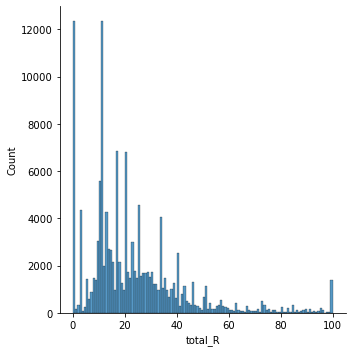

In [154]:

sns.displot(df2[df2['post']<20000]['total_R'],bins=120)

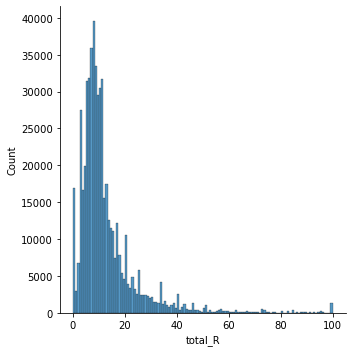

In [155]:
sns.displot(df2['total_R'],bins=120)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/671264884.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_4648/671264884.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


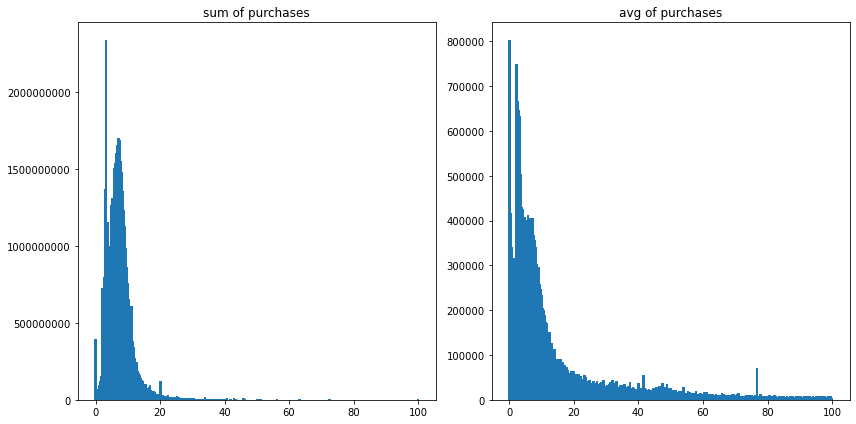

In [156]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df2.groupby('total_R').sum()['pre'].index,df2.groupby('total_R').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df2.groupby('total_R').mean()['pre'].index,df2.groupby('total_R').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [157]:
df2['total_R'].value_counts()

0.000     15865
11.100    13200
3.000     11493
3.200      7497
10.100     5705
          ...  
96.100        1
92.300        1
98.100        1
90.300        1
99.400        1
Name: total_R, Length: 951, dtype: int64

In [158]:
#눈에 띄는 지점 기준으로 나누기
print('~5%')
display(df2[df2['total_R']<5].describe())
print('5~9%')
display(df2[(df2['total_R']>=5) & (df2['total_R']<9)].describe())
print('9~15%')
display(df2[(df2['total_R']>=9) & (df2['total_R']<15)].describe())
print('15%~')
display(df2[df2['total_R']>=15].describe())

~5%


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000,90688.000
mean,272848.112,35.308,0.422,0.403,0.007,307522.749,298638.536,1640.636,8884.213,10524.849,0.762,2.050,2.811,1.000,6.216,0.789
std,157113.911,11.018,0.494,0.491,0.085,1063422.031,1034308.187,6023.597,30538.256,32356.960,1.130,1.677,1.561,0.000,20.568,1.828
min,4.000,15.000,0.000,0.000,0.000,500.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,136714.750,28.000,0.000,0.000,0.000,28567.500,28000.000,0.000,0.000,717.000,0.000,0.000,2.100,1.000,1.000,0.000
50%,272834.500,34.000,0.000,0.000,0.000,93500.000,91000.000,0.000,2000.000,3000.000,0.000,2.300,3.200,1.000,2.000,0.000
75%,408816.500,41.000,1.000,1.000,0.000,275400.000,269200.000,1194.000,7350.000,9350.000,1.400,3.500,4.000,1.000,6.000,0.000
max,544909.000,121.000,1.000,1.000,1.000,115005350.000,112273800.000,851803.000,2731550.000,2731550.000,4.900,4.900,4.900,1.000,2705.000,10.800


5~9%


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000,164562.000
mean,272452.462,36.595,0.297,0.463,0.008,351238.979,329378.067,2536.183,21860.912,24397.095,0.639,6.391,7.030,1.000,17.695,2.189
std,157134.836,10.061,0.457,0.499,0.087,505852.925,475971.935,6626.947,31149.804,34857.378,0.993,1.631,1.124,0.000,26.621,3.076
min,15.000,15.000,0.000,0.000,0.000,1400.000,1400.000,0.000,0.000,70.000,0.000,0.000,5.000,1.000,1.000,0.000
25%,136451.500,29.000,0.000,0.000,0.000,69310.000,64800.000,0.000,4000.000,5000.000,0.000,5.400,6.100,1.000,3.000,0.000
50%,272402.000,36.000,0.000,0.000,0.000,174300.000,163070.500,465.000,10900.000,12000.000,0.200,6.600,7.100,1.000,8.000,0.300
75%,408436.500,42.000,1.000,1.000,0.000,425935.000,398577.250,2357.000,26857.000,29745.750,0.900,7.600,8.000,1.000,21.000,3.600
max,544920.000,121.000,1.000,1.000,1.000,22250915.000,21100913.000,249438.000,1150002.000,1330657.000,5.000,8.900,8.900,1.000,487.000,10.800


9~15%


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000,156457.000
mean,272325.294,37.190,0.329,0.427,0.005,155839.040,139732.542,688.360,16106.498,16794.858,0.305,11.024,11.329,1.000,10.816,1.038
std,157476.498,11.042,0.470,0.495,0.070,266674.796,241346.395,2922.164,25750.535,27476.758,0.722,1.805,1.618,0.000,19.328,2.100
min,6.000,16.000,0.000,0.000,0.000,900.000,800.000,0.000,100.000,100.000,0.000,4.000,9.000,1.000,1.000,0.000
25%,135768.000,30.000,0.000,0.000,0.000,29700.000,26148.000,0.000,3396.000,3500.000,0.000,9.700,10.000,1.000,2.000,0.000
50%,272419.000,37.000,0.000,0.000,0.000,68802.000,60927.000,0.000,7740.000,8000.000,0.000,11.000,11.100,1.000,4.000,0.000
75%,408860.000,42.000,1.000,1.000,0.000,166890.000,148939.000,315.000,17836.000,18365.000,0.200,12.300,12.600,1.000,11.000,1.200
max,544921.000,121.000,1.000,1.000,1.000,8063204.000,7434512.000,114411.000,628692.000,727749.000,5.000,14.900,14.900,1.000,430.000,10.800


15%~


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000,133214.000
mean,272367.396,37.753,0.427,0.364,0.003,37275.140,29239.741,120.273,8035.398,8155.671,0.160,28.028,28.188,1.000,3.423,0.197
std,157446.032,13.969,0.495,0.481,0.059,59521.635,49566.382,896.346,10591.468,11077.264,0.617,16.183,16.121,0.000,6.300,0.762
min,1.000,15.000,0.000,0.000,0.000,2500.000,0.000,0.000,1000.000,1000.000,0.000,10.000,15.000,1.000,1.000,0.000
25%,136084.750,30.000,0.000,0.000,0.000,11600.000,7900.000,0.000,3880.750,3890.000,0.000,17.500,17.800,1.000,1.000,0.000
50%,272349.500,36.000,0.000,0.000,0.000,20800.000,15400.000,0.000,5000.000,5000.000,0.000,22.300,22.500,1.000,1.000,0.000
75%,408709.250,42.000,1.000,1.000,0.000,38579.750,30600.000,0.000,8000.000,8232.000,0.000,32.700,32.800,1.000,3.000,0.000
max,544917.000,121.000,1.000,1.000,1.000,2167429.000,1850084.000,40736.000,555096.000,555096.000,5.000,100.000,100.000,1.000,213.000,10.800


In [159]:
# 점수 생성
def s_total_R(total_R):
    if total_R < 5:
        return 1
    elif 5 <= total_R < 9:
        return 2
    elif 9 <= total_R < 15:
        return 3
    else:
        return 4

## 점수 종합

In [160]:
df2

,id,age,man,push,frgn,birth,sign,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,24330,18960,0,5370,5370,0.000,22.100,22.100,1,2,0.000
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,25030,19359,0,5671,5671,0.000,22.700,22.700,1,2,0.000
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,18120,13440,0,4680,4680,0.000,25.800,25.800,1,1,0.000
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,227640,216980,0,10660,10660,0.000,4.700,4.700,1,8,0.000
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,65170,55170,0,10000,10000,0.000,15.300,15.300,1,6,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544916,544917,27,0,0,0,1994-07-08,2019-08-11 01:56:44.713,41220,34740,0,6480,6480,0.000,15.700,15.700,1,2,0.000
544917,544918,23,0,1,0,1998-02-26,2019-12-08 12:28:08.093,268665,252665,2296,16000,18296,0.900,6.000,6.800,1,21,4.200
544918,544919,41,0,1,0,1980-03-25,2019-08-03 16:06:57.300,529022,483123,177,45899,46076,0.000,8.700,8.700,1,43,4.500
544919,544920,49,1,1,0,1972-02-07,2019-08-31 11:02:08.238,462100,429100,441,33000,33441,0.100,7.100,7.200,1,7,0.000


In [161]:
df2['score'] += df2['age'].apply(s_age)
df2['score'] += df2['man'].apply(s_gender)
df2['score'] += df2['push'].apply(s_push)*2
df2['score'] += df2['post'].apply(s_post)*2
df2['score'] += df2['cnt_b'].apply(s_cnt_b)*3
df2['score'] += df2['total_R'].apply(s_total_R)
df2

,id,age,man,push,frgn,birth,sign,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,24330,18960,0,5370,5370,0.000,22.100,22.100,1,2,26.500
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,25030,19359,0,5671,5671,0.000,22.700,22.700,1,2,25.500
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,18120,13440,0,4680,4680,0.000,25.800,25.800,1,1,30.500
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,227640,216980,0,10660,10660,0.000,4.700,4.700,1,8,37.500
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,65170,55170,0,10000,10000,0.000,15.300,15.300,1,6,43.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544916,544917,27,0,0,0,1994-07-08,2019-08-11 01:56:44.713,41220,34740,0,6480,6480,0.000,15.700,15.700,1,2,27.500
544917,544918,23,0,1,0,1998-02-26,2019-12-08 12:28:08.093,268665,252665,2296,16000,18296,0.900,6.000,6.800,1,21,49.700
544918,544919,41,0,1,0,1980-03-25,2019-08-03 16:06:57.300,529022,483123,177,45899,46076,0.000,8.700,8.700,1,43,53.000
544919,544920,49,1,1,0,1972-02-07,2019-08-31 11:02:08.238,462100,429100,441,33000,33441,0.100,7.100,7.200,1,7,40.500


/Users/luci031/opt/anaconda3/envs/spark/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score', ylabel='Density'>

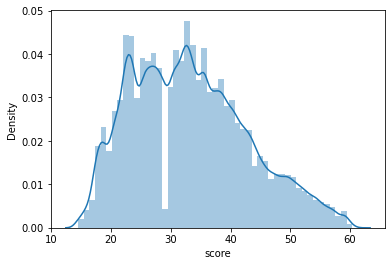

In [162]:
sns.distplot(df2['score'])

## 시간대별

### 날짜별

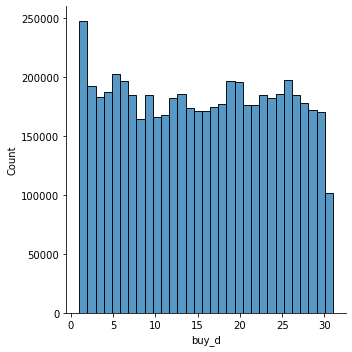

In [177]:
sns.displot(df1['buy_d'],bins=31)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2479/3751378546.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2479/3751378546.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


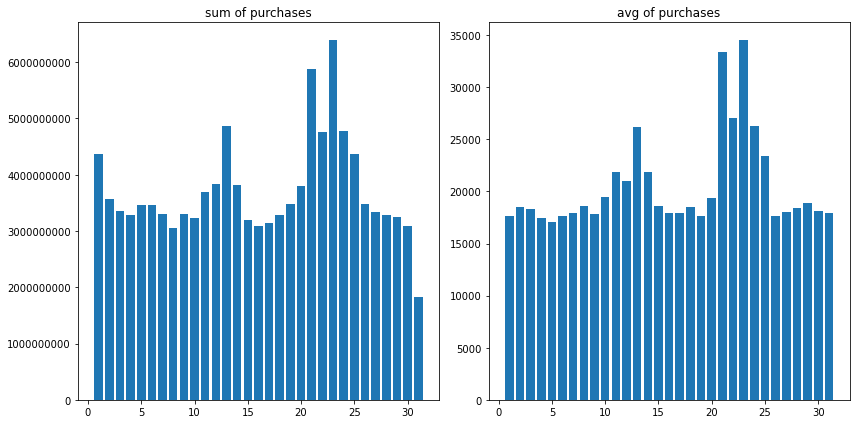

In [178]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df1.groupby('buy_d').sum()['pre'].index,df1.groupby('buy_d').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df1.groupby('buy_d').mean()['pre'].index,df1.groupby('buy_d').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [189]:
# 인당 평균 구매일
a = df1.groupby('id').mean().reset_index()[['id','buy_d']]
def truncs(num):
    return int(num//1)
a['buy_d'] = a['buy_d'].apply(truncs)
a['buy_d'] = a['buy_d'].astype(int)
df3 = df3.merge(a,on='id')

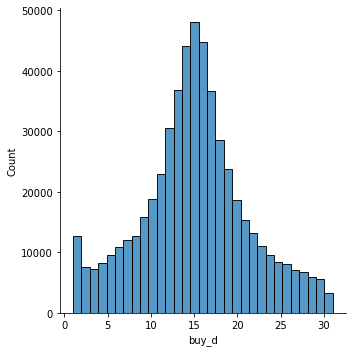

In [196]:
sns.displot(df3['buy_d'],bins=31)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2479/810107199.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2479/810107199.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


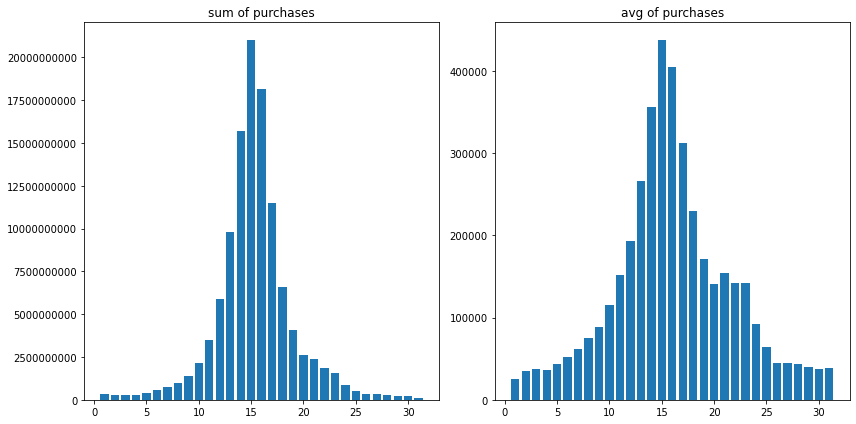

In [197]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df3.groupby('buy_d').sum()['pre'].index,df3.groupby('buy_d').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df3.groupby('buy_d').mean()['pre'].index,df3.groupby('buy_d').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

## 외국인별, merchant_id 별

##